In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from tslearn.metrics import dtw, soft_dtw
from tslearn.utils import to_time_series_dataset
from sklearn.utils.validation import _check_large_sparse
from tslearn.clustering import TimeSeriesKMeans
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

We are dealing with AU values only, using all_videos.csv that we had generated before.

We group the data by file name and face id (to seperate emotions as much as possible) and then split the big chunks of frames to smaller chunks of $50$ frames.

In [3]:
X_df = pd.read_csv('./all_videos.csv', index_col=None)
# target_emotion = 'contempt'
# target_culture = 'North America'
# X_df = X_df[(X_df['emotion'] == target_emotion) & (X_df['culture'] == target_culture)]
print(X_df.head())
# filenames = X['filename'].unique()
# face_ids = X['face_id'].unique()
videos = X_df['filename'].unique()
test_videos = pd.Series(videos).sample(frac=0.20)
valid_videos = pd.Series(test_videos).sample(frac=0.50).values
train_videos = np.array(list(set(videos) - set(test_videos)))
test_videos = np.array(list(set(test_videos) - set(valid_videos)))


   frame  face_id  confidence  success  AU01_r  AU02_r  AU04_r  AU05_r  \
0     33        0        0.98        1    0.94    1.24    1.96    2.17   
1     34        0        0.98        1    0.83    0.83    2.65    2.01   
2     35        0        0.98        1    0.78    0.95    2.69    1.68   
3     36        0        0.98        1    1.11    1.06    2.77    1.34   
4     37        0        0.98        1    1.13    0.92    2.60    1.09   

   AU06_r  AU07_r  ...  AU14_r  AU15_r  AU17_r  AU23_r  AU25_r  AU26_r  \
0    0.29     0.0  ...    0.15    0.35    1.31     0.0    1.35    0.00   
1    0.29     0.0  ...    0.79    0.37    1.40     0.0    1.35    0.13   
2    0.18     0.0  ...    0.92    0.34    1.14     0.0    1.42    0.25   
3    0.26     0.0  ...    1.09    0.47    0.66     0.0    1.74    0.00   
4    0.37     0.0  ...    1.30    0.16    0.59     0.0    1.42    0.00   

   AU45_r  filename  culture   emotion  
0    0.00        28  Persian  contempt  
1    0.26        28  Persian

TODO: Also do without frame limit.

In [4]:
grouped = X_df.groupby(by=['filename', 'face_id'])
## Separating test data
test_ts_list = list()
test_metadata = list()
# X_list is video/face frames, divided into 50 frames chunks
X_list = []
metadata = []
frame_limit = 50
for key in grouped.groups:
    X_group = grouped.get_group(key)
    # X_group = X_group.drop(['frame', 'face_id', 'culture', 'filename', 'emotion', 'confidence','success'], axis=1)
    if len(X_group) >= frame_limit:
        splitted_group = np.array_split(X_group, math.ceil(len(X_group) / frame_limit))
        for g in splitted_group:
            X_list.append(g.drop(['frame', 'face_id', 'culture', 'filename', 'emotion', 'confidence','success'], axis=1).to_numpy())
            metadata.append({'filename': g.loc[g.index[0], 'filename'], 'emotion': g.loc[g.index[0], 'emotion'], 'face_id':g.loc[g.index[0], 'face_id']})
    else:
        X_list.append(X_group.drop(['frame', 'face_id', 'culture', 'filename', 'emotion', 'confidence','success'], axis=1).to_numpy())
        metadata.append({'filename': X_group.loc[X_group.index[0], 'filename'], 'emotion': X_group.loc[X_group.index[0], 'emotion'], 'face_id':X_group.loc[X_group.index[0], 'face_id']})

X_list and Y_list are lists of 728 elements

Training accuracy for k=3: 0.8075601374570447
Validation accuracy for k=3: 0.6232876712328768
Training accuracy for k=4: 0.7680412371134021
Validation accuracy for k=4: 0.5205479452054794
Training accuracy for k=5: 0.7542955326460481
Validation accuracy for k=5: 0.5205479452054794
Training accuracy for k=6: 0.7285223367697594
Validation accuracy for k=6: 0.547945205479452
Training accuracy for k=7: 0.7061855670103093
Validation accuracy for k=7: 0.5342465753424658
Training accuracy for k=8: 0.697594501718213
Validation accuracy for k=8: 0.5616438356164384
Training accuracy for k=9: 0.6804123711340206
Validation accuracy for k=9: 0.5753424657534246
Training accuracy for k=10: 0.6666666666666666
Validation accuracy for k=10: 0.5547945205479452
Training accuracy for k=11: 0.6752577319587629
Validation accuracy for k=11: 0.5273972602739726
Training accuracy for k=12: 0.6683848797250859
Validation accuracy for k=12: 0.5273972602739726
Training accuracy for k=13: 0.647766323024055
Validation

No handles with labels found to put in legend.


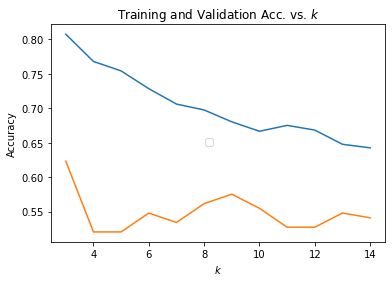

KeyboardInterrupt: 

In [6]:
# TODO: fix copying y_list lines (two lines below:)
# metadata = y_list.copy()
y_list = [x['emotion'] for x in metadata]
# print(X_list[0].shape)
X_ts = to_time_series_dataset(X_list)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
splits = kf.split(videos)
for (i, (train_index, test_index)) in enumerate(splits):
    print('%d-th split' % (i+1))
    X_train, X_test = X_ts[train_index], X_ts[test_index]
    Y_train, Y_test = np.array(y_list)[train_index], np.array(y_list)[test_index]
    K_MAX = 3
    K_MIN = 2
    train_acc = []
    valid_acc = []
    for k in range(K_MIN, K_MAX):
        knn_classifier = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric='dtw')
        knn_classifier.fit(X_train, Y_train)
        train_predicted_labels = knn_classifier.predict(X_train)
        train_acc.append(accuracy_score(Y_train, train_predicted_labels))

        print("Training accuracy for k={}: {}".format(k, train_acc[-1]))
        val_predicted_labels = knn_classifier.predict(X_test)
        valid_acc.append( accuracy_score(Y_test, val_predicted_labels))
        print("Validation accuracy for k={}: {}".format(k, valid_acc[-1]))

    plt.plot(range(K_MIN, K_MAX), train_acc, label='Training Accuracy')
    plt.xlabel('$k$')
    plt.ylabel('Accuracy')
    # plt.show()

    plt.plot(range(K_MIN, K_MAX), valid_acc, label='Validation Accuracy')
    plt.title('CV %d - Training and Validation Acc. vs. $k$' % (i+1))
    plt.xlabel('$k$')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5))
    plt.show()

In [ ]:
K_MAX = 9
sse = []



a = list() # a list, each element is AU values of each video-chunk
print(type(X_list[21][:, 4:20]))
for i in range(len(X_list)):
    # print(np.shape(X_list[i]))
    # print(type(X_list[i][:, 4:20]))
    if len(X_list[i]) > 2:
        a.append(X_list[i][:, 4:20])

X_ts_list = to_time_series_dataset(a) # extends shorter series with nan

for k in range(1, K_MAX + 1):
    kmeans = TimeSeriesKMeans(n_clusters=k, random_state=1, metric="dtw").fit(X_ts_list)
    centroids = kmeans.cluster_centers_
    # clusters size = number of points in dataset
    clusters = kmeans.predict(X_ts_list)
    print('The shape of the cluster centers for k =', str(k))
    print(kmeans.cluster_centers_.shape)
    curr_sse = 0

    # Calculate square of Euclidean distance of each point from its cluster
    # center and add to current WSS.
    for i in range(len(X_ts_list)):
      curr_center = centroids[clusters[i]]
      curr_sse += dtw(curr_center, X_ts_list[i])
      
    sse.append(curr_sse)


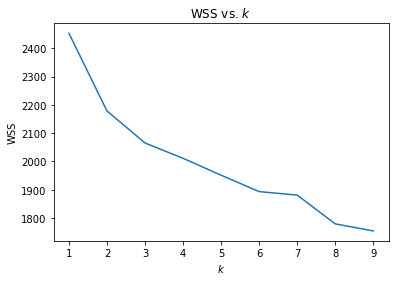

In [4]:
plt.plot(range(1, K_MAX+1), sse)
plt.title('WSS vs. $k$')
plt.xlabel('$k$')
plt.ylabel('WSS')
plt.show()

Based on *WSS vs. k*, it looks like there is an arm with a clear elbow at $k=3$.

In [19]:

K = 3
kmeans = TimeSeriesKMeans(n_clusters=K, random_state=1, metric='dtw')
clusters = kmeans.fit_predict(X_ts_list)
num_clusters = kmeans.n_clusters
cluster_centers = kmeans.cluster_centers_


In [20]:
print(clusters.shape)
print(clusters[0])
print(num_clusters)
print(cluster_centers.shape)


(123,)
1
3
(3, 50, 16)


In [21]:
cluster_centers.shape
closest_points = [None] * K
min_dist = [math.inf] * K
cluster_labels = [ list(), list(), list()]
unique, counts = np.unique(clusters, return_counts=True)
print('Number of instances per cluster: ', dict(zip(unique, counts)))
# print(cluster_centers.count(1))
# print(cluster_centers.count(2))

for i in range(len(X_ts_list)):
    index = clusters[i]
    curr_center = cluster_centers[index]
    dist = soft_dtw(curr_center, X_ts_list[i])
    cluster_labels[index].append(X_list[i][0][21])

    # print('cluster [', index , ']: ', cluster_labels[index])
    if dist < min_dist[index]:
        min_dist[index] = dist
        closest_points[index] = i

print('The closest points to each centroids are', closest_points)


Number of instances per cluster:  {0: 49, 1: 39, 2: 35}
The closest points to each centroids are [46, 117, 6]


Here we remove the chunks that have <2 frames, since they do not exist in timeseries format.

In [22]:
X_list = [item for item in X_list if len(item) > 2]
print(len(X_list))

123


Get video files:

In [23]:
for c in closest_points:
    print(X_list[c][0])
    # print(X_ts_list[c][0])

[1 0 0.98 1 0.0 0.0 0.0 0.74 0.3 0.9 0.86 0.45 0.43 0.36 0.0 0.0 0.0 0.56
 0.14 0.0 'contempt_21' 'North America' 'contempt']
[44 0 0.98 1 0.45 2.09 0.0 0.0 0.0 0.0 0.0 0.0 1.09 0.0 0.11 0.0 0.0 1.11
 0.83 0.0 'contempt_9' 'North America' 'contempt']
[85 2 0.98 1 0.0 0.0 0.09 0.81 0.83 0.49 0.7 0.26 1.53 0.91 0.0 0.0 0.0
 2.17 0.6 0.0 'contempt_1' 'North America' 'contempt']


Calculate average AU of each 50 frame videos:

In [24]:
avg = []
np.set_printoptions(precision=3, suppress=True)
for i in range(len(X_list)):
    # print(np.shape(X_list[i]))
    # print(type(X_list[i][:, 4:20]))
    if len(X_list[i]) > 2:
        avg.append(np.mean(X_list[i][:, 4:20], axis=0).astype(np.float))

In [25]:
X_ts_list.shape

(123, 50, 16)

In [26]:
peaks = []
for i in range(len(X_list)):
    # print(np.shape(X_list[i]))
    # print(type(X_list[i][:, 4:20]))
    if len(X_list[i]) > 2:
        peaks.append(np.max(X_list[i][:, 4:20], axis=0).astype(np.float))
# peaks = np.nanmean(X_list[:, :, 4:20], axis=1).astype(np.float)
# print(peaks.shape)
print(peaks[5])
print('*************')
print(avg[5])

[0.   0.   0.81 0.87 1.06 0.85 0.85 0.57 1.84 1.24 0.   0.   0.   2.36
 1.23 0.1 ]
*************
[0.    0.    0.307 0.443 0.71  0.341 0.667 0.332 1.503 0.943 0.    0.
 0.    2.039 0.85  0.005]


In [27]:
# since each a[i] is a matrix (video time series), we want the avg or the max of this time series (max = peak of emotion) to visualize it.

to_vis = np.vstack(avg)

Reducing dimensionality of points to visualize them:    


In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
to_vis_reduced = pca.fit_transform(to_vis)

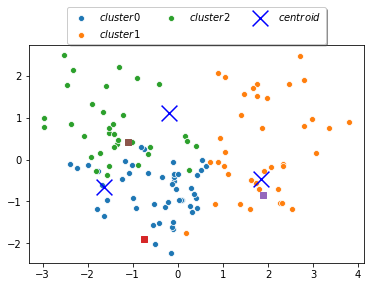

In [29]:
for cluster_num in range(kmeans.n_clusters):
    sns.scatterplot(
        x=to_vis_reduced[clusters == cluster_num, 0], y=to_vis_reduced[clusters == cluster_num, 1], label='$cluster %i$'%cluster_num
    )
for c in closest_points:
    plt.scatter(
        x=to_vis_reduced[c, 0], y=to_vis_reduced[c, 1], marker='s'
    )
# dimensionality reduction for cluster centroids.
cc_red = pca.fit_transform(cluster_centers[:, 25])

plt.scatter(
    x=cc_red[:, 0], y=cc_red[:, 1],
    s=250, marker='x', c='blue', label='$centroid$'
)
plt.title('Social signal clusters for Persian/contempt')
# plt.legend(['1', '2', '3', '4', '5', 'centroid'])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
          ncol=3, fancybox=True, shadow=True)

Get file name and labels of the closest pairs:

AU01_r, AU02_r, AU04_r, AU05_r, AU06_r, AU07_r, AU09_r, AU10_r, AU12_r, AU14_r, AU15_r, AU17_r, AU23_r, AU25_r, AU26_r, AU45_r


In [30]:
df = pd.DataFrame(columns=X_df.columns[4:20], data=np.vstack(avg))
df.head

<bound method NDFrame.head of        AU01_r    AU02_r  AU04_r    AU05_r    AU06_r    AU07_r    AU09_r  \
0    1.524706  1.898235     0.0  0.353824  0.409706  0.739706  0.297941   
1    1.147941  1.684118     0.0  0.598235  0.316176  0.439412  0.373824   
2    0.850244  1.139512     0.0  1.169024  0.690976  0.191951  0.000000   
3    0.773000  1.122250     0.0  1.235500  0.768750  0.634750  0.000000   
4    0.759000  1.045250     0.0  1.517000  0.767500  0.584500  0.000000   
..        ...       ...     ...       ...       ...       ...       ...   
118  1.078605  3.185349     0.0  0.466279  0.069767  0.577907  0.009302   
119  0.207907  1.413953     0.0  0.202093  0.832326  0.496744  0.251628   
120  0.000000  0.308837     0.0  0.000000  1.370233  1.012558  0.015116   
121  0.581860  2.065581     0.0  0.527209  0.013256  0.085814  0.000000   
122  0.541395  2.224884     0.0  0.919535  0.064651  0.071860  0.129302   

       AU10_r    AU12_r    AU14_r    AU15_r    AU17_r    AU23_r    AU

In [31]:
centroids[0]

array([[1.95 , 2.147, 0.   , 0.838, 0.228, 0.39 , 0.117, 0.31 , 0.648,
        0.61 , 1.207, 0.345, 0.027, 0.795, 0.205, 1.295],
       [2.062, 2.287, 0.   , 0.828, 0.165, 0.403, 0.123, 0.288, 0.777,
        0.685, 1.137, 0.205, 0.027, 1.102, 0.185, 1.333],
       [2.053, 2.042, 0.   , 0.509, 0.113, 0.29 , 0.087, 0.292, 0.709,
        0.731, 1.176, 0.139, 0.018, 1.396, 0.121, 1.817],
       [2.055, 2.227, 0.   , 0.598, 0.112, 0.43 , 0.13 , 0.27 , 0.695,
        0.712, 1.083, 0.175, 0.027, 1.147, 0.375, 1.372],
       [2.01 , 2.198, 0.   , 0.555, 0.112, 0.422, 0.13 , 0.287, 0.7  ,
        0.797, 1.023, 0.32 , 0.027, 0.917, 0.23 , 1.393],
       [2.008, 2.192, 0.   , 0.563, 0.138, 0.39 , 0.13 , 0.258, 0.717,
        0.817, 0.997, 0.342, 0.027, 0.817, 0.23 , 1.383],
       [2.02 , 2.158, 0.118, 0.61 , 0.145, 0.39 , 0.13 , 0.348, 0.752,
        0.817, 1.017, 0.413, 0.027, 0.655, 0.347, 1.4  ],
       [1.95 , 2.112, 0.   , 0.642, 0.182, 0.383, 0.13 , 0.352, 0.732,
        0.795, 0.987, 0.17

Drawing radar diagrams to visualize mean of AUs for each cluster:

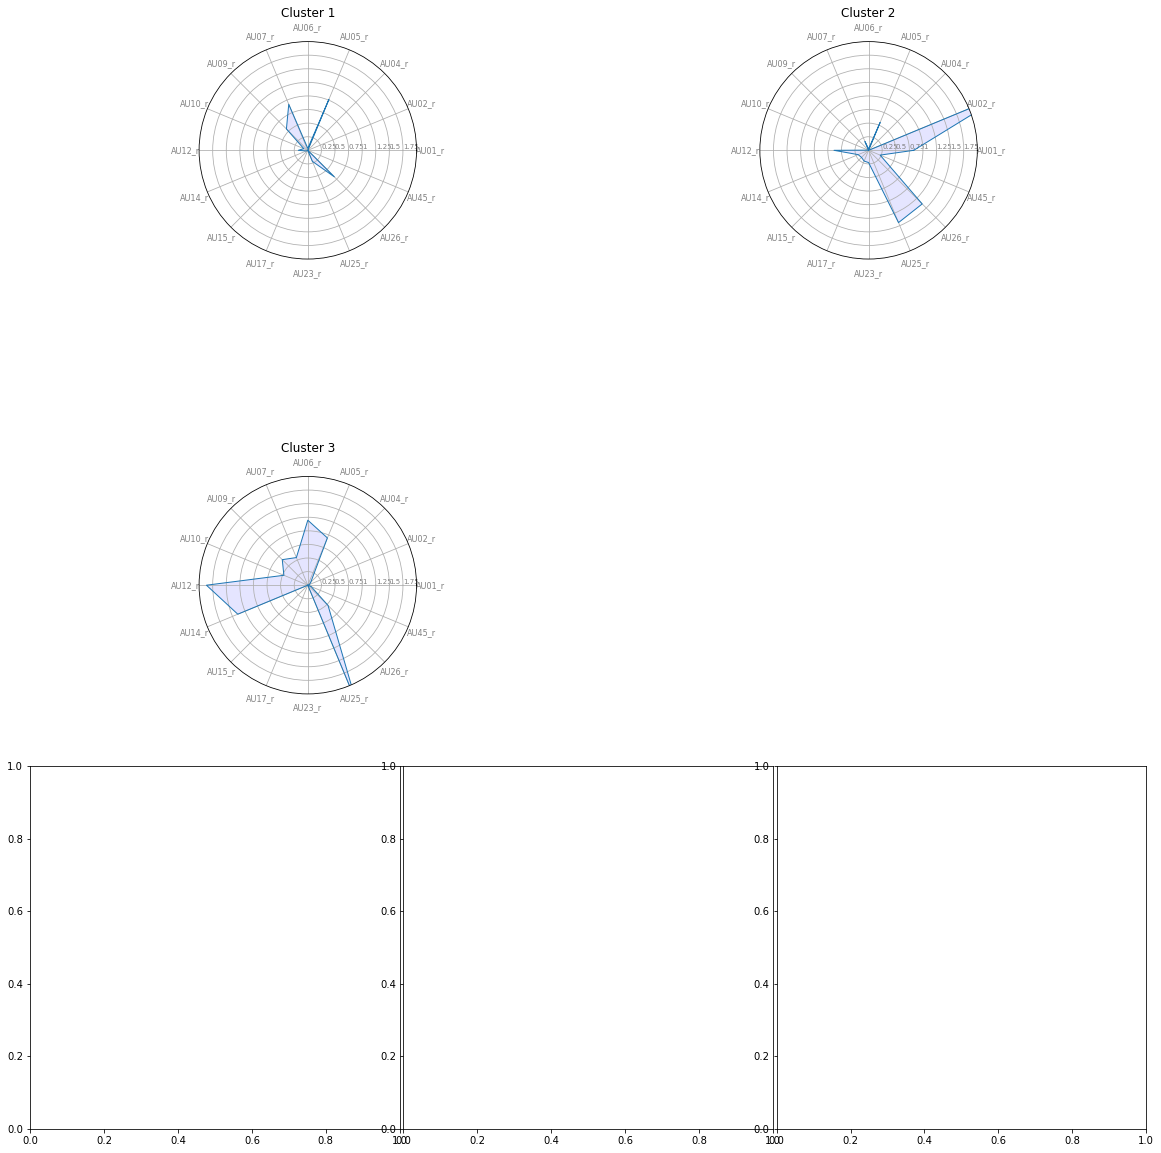

In [32]:
## TODO: refactor as utils
from math import pi
# number of variable
# list(df) returns col headers
categories=list(df)
N = len(categories)
fig, axs = plt.subplots(2, 3, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.01)
axs = axs.ravel()
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
for (i, c) in enumerate(closest_points):
    values=avg[c].tolist()
    # print(len(values))
    # print('******************      ', values)
    # print(values)
    # values = values.values.flatten().tolist()
    # print(values)
    values.append(values[0])
    # print('%%%%%%%%%%%%%%           ', values, len(values))

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles.append(angles[0])
    # print('%%%%%%%%%%%%%%           ', angles, len(angles))
    # Initialise the spider plot
    axs[i] = plt.subplot(321 + i, polar=True)
    
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    # Draw ylabels
    axs[i].set_rlabel_position(0)
    plt.yticks([0.25,0.5,0.75, 1.0, 1.25, 1.5, 1.75], ["0.25","0.5","0.75", "1", "1.25", "1.5", '1.75'], color="grey", size=7)
    plt.ylim(0,2.0)
    
    # Plot data
    axs[i].plot(angles, values, linewidth=1, linestyle='solid')
    
    axs[i].set_title('Cluster ' + str(i+1))
    # Fill area
    axs[i].fill(angles, values, 'b', alpha=0.1)

In [33]:
centroids_avg = []
print(len(cluster_centers))
for i in range(len(cluster_centers)):
    # print(np.shape(X_list[i]))
    print(cluster_centers[i].shape)
    centroids_avg.append(np.mean(centroids[i][:], axis=0).astype(np.float))
centroids_avg

3
(50, 16)
(50, 16)
(50, 16)


[array([1.601, 1.731, 0.025, 0.783, 0.425, 0.758, 0.204, 0.399, 0.91 ,
        0.805, 1.211, 0.478, 0.077, 0.653, 0.255, 1.021]),
 array([0.658, 1.946, 0.016, 0.863, 0.213, 0.297, 0.089, 0.386, 1.206,
        0.315, 0.203, 0.132, 0.178, 2.064, 1.484, 0.245]),
 array([0.422, 1.452, 0.105, 0.066, 0.355, 0.516, 0.314, 0.702, 1.   ,
        0.106, 0.195, 0.133, 0.016, 1.874, 1.356, 3.31 ])]